In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import mpmath
import struct
import json
from matplotlib import cm # colormaps
# from numba import jit
%load_ext line_profiler

In [ ]:
# PI elliptical integral
def ellippi(n, m):
    return sp.special.elliprf(0., 1. - m, 1.) + (n / 3.) * sp.special.elliprj(0., 1. - m, 1., 1. - n)

## Definitions & Potential calculation

In [ ]:
M = 1
G = 6.67430e-11

class Ring():
    def __init__(self, name, radius_start, radius_end, mass=None, sigma0=None):
        self.name = name
        self.r0 = radius_start
        self.r1 = radius_end
        if sigma0:
            self.sigma0 = sigma0
            self.mass = sigma0 * (np.pi * radius_end**2 - np.pi * radius_start**2)
        else:
            self.mass = mass
            self.sigma0 = mass / (np.pi * radius_end**2 - np.pi * radius_start**2)

    def __str__(self):
        return f'{self.name}: {self.r0=}, {self.r1=}, with {self.mass=} and {self.sigma0=}'

# Saturn's rings

ringc = Ring('Ring C', 74.658e6, 91.975e6, sigma0=40) 
ringb = Ring('Ring B', 91.975e6, 117.68e6, sigma0=700)
ringcd = Ring('Ring Cassini Division', 117.68e6, 122.17e6, sigma0=190)
ringa = Ring('Ring A', 122.17e6, 136.775e6, sigma0=300)

rings = [ringc, ringb, ringcd, ringa]
total_mass = sum([ring.mass for ring in rings])
print("Total mass = ", total_mass, " kg")

Total mass =  1.6421212058810935e+19  kg


<>:10: SyntaxWarning: invalid escape sequence '\S'
<>:10: SyntaxWarning: invalid escape sequence '\S'
C:\Users\Alexander\AppData\Local\Temp\ipykernel_1388\2412113245.py:10: SyntaxWarning: invalid escape sequence '\S'
  plt.ylabel("$\Sigma_0$ (kg/m$^2$)")


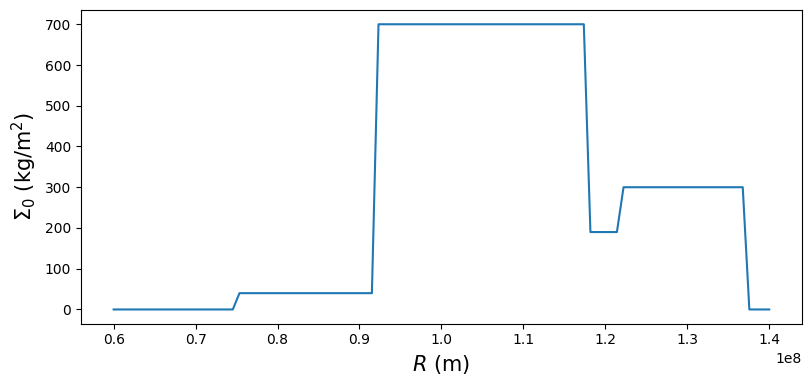

In [ ]:
# Figure of density

N = 100
total_ring = np.zeros(N)
R = np.linspace(60e6, 140e6, N)
for ring in rings:
    total_ring += ring.sigma0 * (np.heaviside(R - ring.r0, 1) - np.heaviside(R - ring.r1, 1))

plt.figure(figsize=(8.16,3.9))
plt.plot(R, total_ring)
plt.xlabel("$R$ (m)")
plt.ylabel("$\Sigma_0$ (kg/m$^2$)")
# plt.title("Approximation of $\\rho=\\Sigma_0(r)\\delta(z)$")

plt.tight_layout()
plt.savefig('./images/approximation_density_rings.pdf')

plt.show()

Code to calculate ring potential of Saturn

In [ ]:
# r0 = 92e6
# r1 = 117.68e6
# mass_bring = 10e18
# Sigma_0 = mass_bring / (np.pi * r1**2 - np.pi * r0**2) # sigma0: kg/m2

# Potential: simple ring
# def pot(R, z):
#     ring_dist2 = (R+a)**2 + z**2
    # return -2/np.pi * G*M/np.sqrt(ring_dist2) * sp.special.ellipk(4*R*a/ring_dist2)

# I_10 ^-1, use a = r_1|r_0, b = r, s = |z|; uses HP-format
# Calculates Laplace integral of x^-1 J_1(ax) J_0(bx) w.r.t. s
def laplacian_besselproduct(a, b, s, ignore_quadrature=False):
    if a == 0:
        a = 1
    if b == 0:
        b = 1
    
    # Otherwise: divide by zero
    if s == 0:
        if b < a:
            return 2/np.pi * sp.special.ellipe((b/a)**2)
        else:
            return 2/np.pi * ((a/b-b/a) * sp.special.ellipk((a/b)**2) + b/a * sp.special.ellipe((a/b)**2))

    # Custom implementation for r < r_1, z != 0
    # otherwise elliptical integrals cause discontinuity
    if b <= a and s != 0:
        return sp.integrate.quad(besselproduct_integrand_usub, 0, np.inf, args=(a, b, s), limit=500)[0]

    A = np.sqrt((a+b)**2 + s**2)
    B = np.sqrt((a-b)**2 + s**2)
    L1 = (A-B)/2
    L2 = (A+B)/2
    k = L1/L2

    E = sp.special.ellipe(k**2)
    K = sp.special.ellipk(k**2)

    if a < b: # r_1/r_0 < r
        # Original implementation, only run if ignore_quadrature=True
        # if ignore_quadrature:
        n_ab = k*a/b
        PI_ab = ellippi(n_ab, k**2)
        return 2*L2/(np.pi*a) * (E - K + a**2/L2**2 * K + s**2/L2**2 * (K - PI_ab))
        # else:
        #     return sp.integrate.quad(besselproduct_integrand, 0, np.inf, args=(a, b, s), limit=500)[0]
    else:
        n_ba = k*b/A
        PI_ba = ellippi(n_ba, k**2)
        return 2*L2/(np.pi*a) * (E - K + a**2/L2**2 * K + s**2/L2**2 * (PI_ba - np.pi*L2/(2*s)))

# using ENS-4.6, only used for comparison but otherwise not used in the analysis
def laplacian_besselproduct_ens(a, b, s):
    if a == 0:
        a = 0.00001
    if b == 0:
        b = 0.00001
    
    # Otherwise: divide by zero
    if s == 0:
        if b < a:
            return 2/np.pi * sp.special.ellipe((b/a)**2)
        else:
            return 2/np.pi * ((a/b-b/a) * sp.special.ellipk((a/b)**2) + b/a * sp.special.ellipe((a/b)**2))
    
    kappa = 2*np.sqrt(a*b/((a+b)**2 + s**2))
    nu = 4*a*b/((a+b)**2)
    K = sp.special.ellipk(kappa**2)
    E = sp.special.ellipe(kappa**2)
    Lambda = np.abs(a - b)/(a + b) * s/np.sqrt((a+b)**2 + s**2) * ellippi(nu, kappa)
    return 1/(np.pi * a) * (2*np.sqrt(a*b)/kappa * E + (a**2 - b**2) * kappa/(2*np.sqrt(a*b)) * K) \
        + s/(np.pi * a) * np.sign(a - b) * Lambda  - s/a * np.heaviside(a - b, 1)

# Integrand for quadrature integration, for big values of a, b use _usub variant
def besselproduct_integrand(x, a, b, s):
    return 1/x * sp.special.jv(1, a*x) * sp.special.jv(0, b*x) * np.exp(-np.abs(s)*x)

# see besselproduct_integrand, uses usub u=bx to account for calculation errors due to large numbers in Bessel functions
def besselproduct_integrand_usub(u, a, b, s): # use u-sub: u=bx to integrate small values
    return 1/u * sp.special.jv(1, a*u/b) * sp.special.jv(0, u) * np.exp(-np.abs(s) * u/b)

# def laplacian_besselproduct_quadrature(a, b, s):
def laplacian_besselproduct_quadrature(a, b, s, limit=500):
    if a == 0:
        return 0
    return sp.integrate.quad(besselproduct_integrand_usub, 0, np.inf, args=(a, b, s), limit=limit)[0]

# Calculate potential of a single ring (annulus) at radius R and z; quadrature was used for Laplace integral but is not used anymore
def pot(R, z, ring, quadrature=False):
    laplace_r1 = 0
    laplace_r0 = 0
    if quadrature:
        laplace_r1 = ring.r1 * laplacian_besselproduct_quadrature(ring.r1, R, abs(z))
        laplace_r0 = ring.r0 * laplacian_besselproduct_quadrature(ring.r0, R, abs(z))
    else:
        laplace_r1 = ring.r1 * laplacian_besselproduct(ring.r1, R, abs(z))
        laplace_r0 = ring.r0 * laplacian_besselproduct(ring.r0, R, abs(z))
    return 2 * np.pi * G * ring.sigma0 * (laplace_r1 - laplace_r0)

# Calculate total ring potential for rings of Saturn
def pot_rings(R, z, quadrature=False):
    return np.sum([pot(R, z, ring, quadrature=quadrature) for ring in rings])

# Below: unused code, but maybe useful to store

def force_cyl_approx(R, z, dR, dz):
    pot_point = np.vectorize(pot_rings)(R, z)
    diff_R = (pot_rings(R+dR, z) - pot_point)/dR
    diff_z = (pot_rings(R, z+dz) - pot_point)/dz
    return (-diff_R, 0, -diff_z)

def force_xyz_approx(x, y, z, dR, dz):
    R = np.sqrt(x**2 + y*2)
    phi = np.atan2(y, x)
    force_cyl = force_cyl_approx(R, z, dR, dz)

    matrix = np.array([[np.cos(phi), -np.sin(phi), 0],
                      [np.sin(phi), np.cos(phi), 0],
                      [0, 0, 1]])
    
    return np.linalg.matmul(matrix, force_cyl) # cylinder -> xyz

# assume y = 0 since axisymmetric
def force_xyz_approx_y0(x, z, dR, dz):
    R = x
    phi = 0
    force_cyl = force_cyl_approx(R, z, dR, dz)

    matrix = np.array([[1, 0, 0],
                      [0, 1, 0],
                      [0, 0, 1]])
    
    return np.linalg.matmul(matrix, force_cyl) # cylinder -> xyz

### Analysis difference Elliptical integrals vs. Quadrature



Max error elliptical-quadrature = 2.0813458179169686e-09
Max error integration = 1.4766245942985139e-08


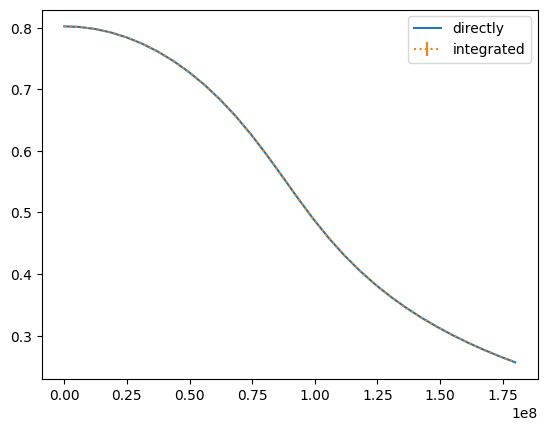

In [7]:
center = 90e6
r = np.linspace(3_000, 2*center, 30)
z = 20e6
directly = np.array([laplacian_besselproduct(center, r_v, z, ignore_quadrature=True) for r_v in r])
# print(f"{directly=}")

integrated = np.array(
    [sp.integrate.quad(besselproduct_integrand_usub, 0, np.inf, args=(center, r_v, z), limit=500)
     for r_v in r])

error = [integrated[k][1] for k in range(len(integrated))]
integrated = [integrated[k][0] for k in range(len(integrated))]
# print(f"{integrated=}")

print(f"Max error elliptical-quadrature = {max(directly-integrated)}")
print(f"Max error integration = {max(error)}")
# plt.errorbar(r, directly-integrated, yerr=error, label='difference', ls='dotted', marker='o')
plt.plot(r, directly, label='directly')
# plt.plot(r, integrated, label='integrated')
plt.errorbar(r, integrated, yerr=error, label='integrated', ls='dotted')
# plt.xlim(0, 0.4)
# plt.ylim((1-0.01, 1+0.01))
plt.legend()
plt.show()

## Project Images

In [7]:
def derivative_at(r0, z0, dr=1e3):
    return (pot_rings(r0+dr, z0)-pot_rings(r0, z0))/dr

def derivative_at_dz(r0, z0, dz=1e3):
    return (pot_rings(r0, z0+dz)-pot_rings(r0, z0))/dz

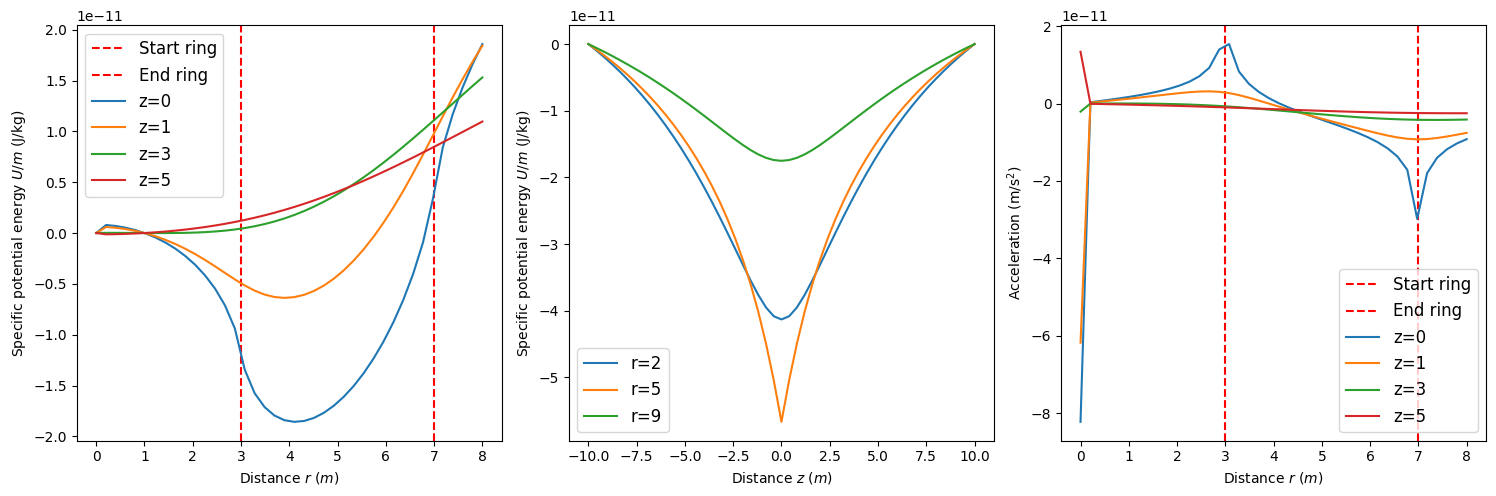

In [9]:
test_ring = Ring('Test ring', 3, 7, mass=5)
test_r = np.linspace(0, 8, 40)
z_items = [0, 1, 3, 5]
test_pot = [np.array([pot(r, z_v, test_ring) for r in test_r]) for z_v in z_items]
test_specific_energy = [test_pot[k][0] - test_pot[k] for k in range(len(z_items))]
# test_z = np.linspace(-5, 5, 101)

def __derivative_at_ring(r0, z0, ring, dr=0.01):
    return (pot(r0+dr, z0, ring, quadrature=False) - pot(r0, z0, ring, quadrature=False))/dr

def __derivative_at_ring_dz(r0, z0, ring, dz=0.1):
    return (pot(r0, z0+dz, ring, quadrature=False) - pot(r0, z0, ring, quadrature=False))/dz

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

ax1.set_xlabel('Distance $r$ ($m$)')
ax1.set_ylabel('Specific potential energy $U/m$ (J/kg)')
ax1.axvline(3, ls='--', color='red', label='Start ring')
ax1.axvline(7, ls='--', color='red', label='End ring')
for i in range(len(z_items)):
    ax1.plot(test_r, test_specific_energy[i], label=f'z={z_items[i]}')
ax1.legend()


test_z = np.linspace(-10, 10, 51)
r_items = [2, 5, 9]
test_pot_z = [np.array([pot(r_v, z, test_ring) for z in test_z]) for r_v in r_items]
test_specific_energy_z = [test_pot_z[k][0] - test_pot_z[k] for k in range(len(r_items))]
ax2.set_xlabel('Distance $z$ ($m$)')
ax2.set_ylabel('Specific potential energy $U/m$ (J/kg)')
for i in range(len(r_items)):
    ax2.plot(test_z, test_specific_energy_z[i], label=f'r={r_items[i]}')
ax2.legend()


ax3.axvline(3, ls='--', color='red', label='Start ring')
ax3.axvline(7, ls='--', color='red', label='End ring')
for i in range(len(z_items)):
    accel_r = np.array([__derivative_at_ring(r0, z_items[i], test_ring) for r0 in test_r])
    accel_z = np.array([__derivative_at_ring_dz(r0, z_items[i], test_ring) for r0 in test_r])
    accel = np.sqrt(accel_r**2 + accel_z**2)
    ax3.plot(test_r, accel_r, label=f'z={z_items[i]}')

# ax2.plot(test_r, accel)
# ax2.plot(test_r, [__derivative_at_ring(r0, 0, test_ring) for r0 in test_r])
ax3.set_xlabel('Distance $r$ ($m$)')
ax3.set_ylabel('Acceleration (m/s$^2$)')

ax3.legend()

fig.tight_layout()
fig.savefig('./images/plot_potential.pdf')
# plt.show()

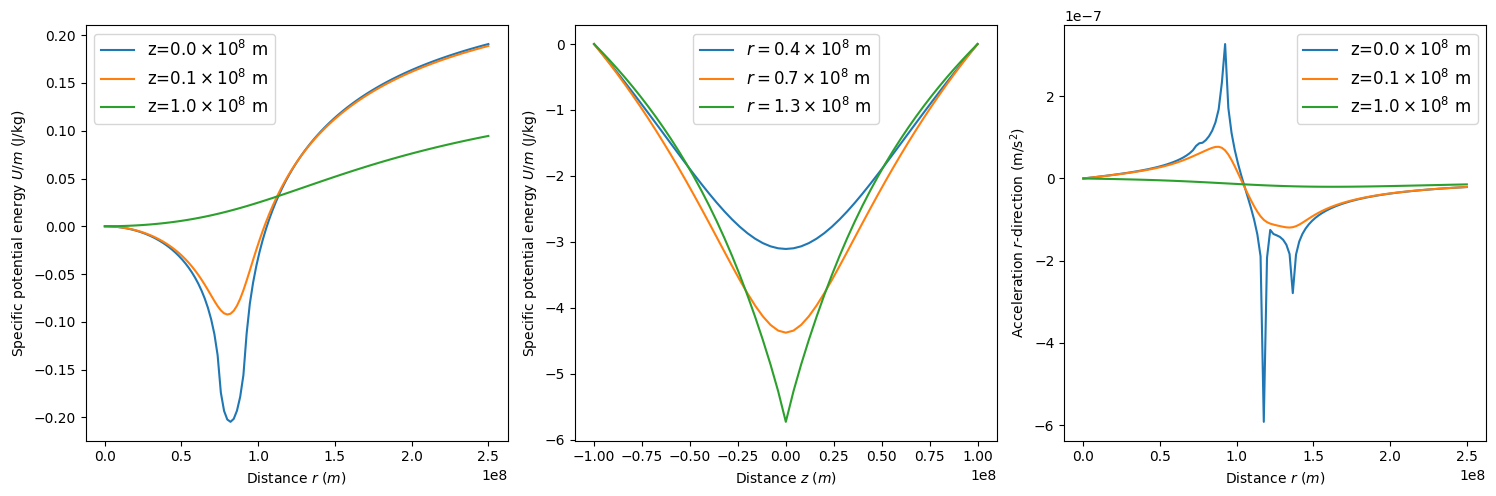

In [8]:
# test_ring = Ring('Test ring', 3, 7, mass=5)
test_r = np.linspace(50_000, 2.5e8, 120)
z_items = [0, 10e6, 100e6]
z_labels = ['$0.0 \\times 10^8$', '$0.1\\times 10^8$', '$1.0 \\times 10^8$']
test_pot = [np.array([pot(r, z_v, rings[0]) for r in test_r]) for z_v in z_items]
# test_pot = [np.array([sum([pot(r, z_v, ring) for ring in rings]) for r in test_r]) for z_v in z_items]
test_specific_energy = [test_pot[k][0] - test_pot[k] for k in range(len(z_items))]

# test_z = np.linspace(-5, 5, 101)

# def __derivative_at_ring(r0, z0, ring, dr=0.01):
#     return (pot(r0+dr, z0, ring, quadrature=False) - pot(r0, z0, ring, quadrature=False))/dr

# def __derivative_at_ring_dz(r0, z0, ring, dz=100):
#     return (pot(r0, z0+dz, ring, quadrature=False) - pot(r0, z0, ring, quadrature=False))/dz

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
# plt.xkcd()

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

ax1.set_xlabel('Distance $r$ ($m$)')
ax1.set_ylabel('Specific potential energy $U/m$ (J/kg)')
# ax1.axvline(3, ls='--', color='red', label='Start ring')
# ax1.axvline(7, ls='--', color='red', label='End ring')
for i in range(len(z_items)):
    ax1.plot(test_r, test_specific_energy[i], label=f'z={z_labels[i]} m')
ax1.legend()



test_z = np.linspace(-1e8, 1e8, 51)
r_items = [0.4e8, 0.7e8, 1.3e8]
r_labels = ['$0.4\\times 10^8$', '$0.7\\times 10^8$', '$1.3 \\times 10^8$']
test_pot_z = [np.array([pot_rings(r_v, z) for z in test_z]) for r_v in r_items]
test_specific_energy_z = [test_pot_z[k][0] - test_pot_z[k] for k in range(len(r_items))]
ax2.set_xlabel('Distance $z$ ($m$)')
ax2.set_ylabel('Specific potential energy $U/m$ (J/kg)')
for i in range(len(r_items)):
    ax2.plot(test_z, test_specific_energy_z[i], label=f'$r=${r_labels[i]} m')
ax2.legend()



for i in range(len(z_items)):
    accel_r = np.array([derivative_at(r0, z_items[i]) for r0 in test_r])
    ax3.plot(test_r, accel_r, label=f'z={z_labels[i]} m')

ax3.set_xlabel('Distance $r$ ($m$)')
ax3.set_ylabel('Acceleration $r$-direction (m/s$^2$)')
ax3.legend()


# for i in range(len(r_items)):
#     accel_z = np.array([derivative_at_dz(r_items[i], z0, dz=80e6) for z0 in test_z])
#     ax4.plot(test_z, accel_z, label=f'r={r_labels[i]} m')

# ax4.set_xlabel('Distance $z$ ($m$)')
# ax4.set_ylabel('Acceleration $z$-direction (m/s$^2$)')
# ax4.legend()


fig.tight_layout()
# fig.savefig('./images/plot_potential_rings.pdf')
plt.show()

## Actual Analysis

In [39]:
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

### Initialize matrix parameters for potential calculation

In [41]:
# R = np.linspace(5e8, 10e9, 500) # 50e6, 500e6

# R = np.linspace(1e6, 5e8, 40) # 500
R = np.linspace(1e6, 5e8, 500) # 500

# R = np.linspace(5e8, 100e8, 30)
# approximation GM/r from 5e7
z = np.linspace(-100e6, 100e6, 400+1) # 401
# z = np.linspace(-5, 0, 5, 3)

R_R, Z_Z = np.meshgrid(R, z)
# potential = pot(R, z)

### Forces

Code below was for simple checks for discontinuities in derivatives.
Is obsolete now: use 3D surface plot below

In [ ]:
# forces = [derivative_at(0.7e8, z_v) for z_v in z]

# plt.xlabel('z (m)')
# plt.ylabel('$\\frac{\\partial V}{\\partial z}$ (m/s^2)')
# plt.plot(z, forces, label='R=$0.7\\times 10^8$ m')
# # plt.plot(R[400:], forces[400:], label=f'z=0')
# # plt.plot(R[400:], -1*G*mass_bring/((R[400:])**2), label=f'1/r2')
# plt.legend()
# plt.show()

In [1]:
# # Zet dit in de appendix
# # forces = [derivative_at(r, 0) for r in R]

# plt.figure(figsize=(4,4))

# plt.xlabel('R (m)')
# plt.ylabel('Relative error from $GM/r$ approximation (%)')
# plt.plot(R[5:], ((forces + 1*G* total_mass / ((R)**2))/forces*100)[5:], label=f'z=0')
# # plt.plot(R[400:], , label=f'1/r2')

# plt.legend()
# # plt.savefig('./images/plot gmr approx.pdf')
# plt.show()

Generates forces from simple forward difference scheme (derivative function was defined earlier at project images)

In [22]:
# forces: derivative in R, forces_z: derivative in Z
forces = np.zeros((len(R), len(z)))
forces_z = np.zeros((len(R), len(z))) 

total_iterations = len(R)*len(z)
zero_forces = False

def generate_forces():
    for i in range(len(R)):
        for j in range(len(z)):
            cur_iter = j + i*len(R)
            if cur_iter % 500 == 0:
                print(f"{cur_iter/total_iterations*100:.2f}%")
            R0 = R[i]
            z0 = z[j]
            forces[i, j] = 0 if zero_forces else derivative_at(R0, z0)
            forces_z[i, j] = 0 if zero_forces else derivative_at_dz(R0, z0, dz=80e3)

generate_forces()

0.00%


C:\Users\Alexander\AppData\Local\Temp\ipykernel_1388\1249544515.py:27: IntegrationWarning: The maximum number of subdivisions (500) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return sp.integrate.quad(besselproduct_integrand_usub, 0, np.inf, args=(a, b, s), limit=500)[0]


47.62%
95.24%
142.86%
190.48%


C:\Users\Alexander\AppData\Local\Temp\ipykernel_1388\957458725.py:11: UserWarning: Adding colorbar to a different Figure <Figure size 1000x1000 with 2 Axes> than <Figure size 1500x500 with 3 Axes> which fig.colorbar is called on.
  fig.colorbar(surface, fraction=0.03, pad=0.15)


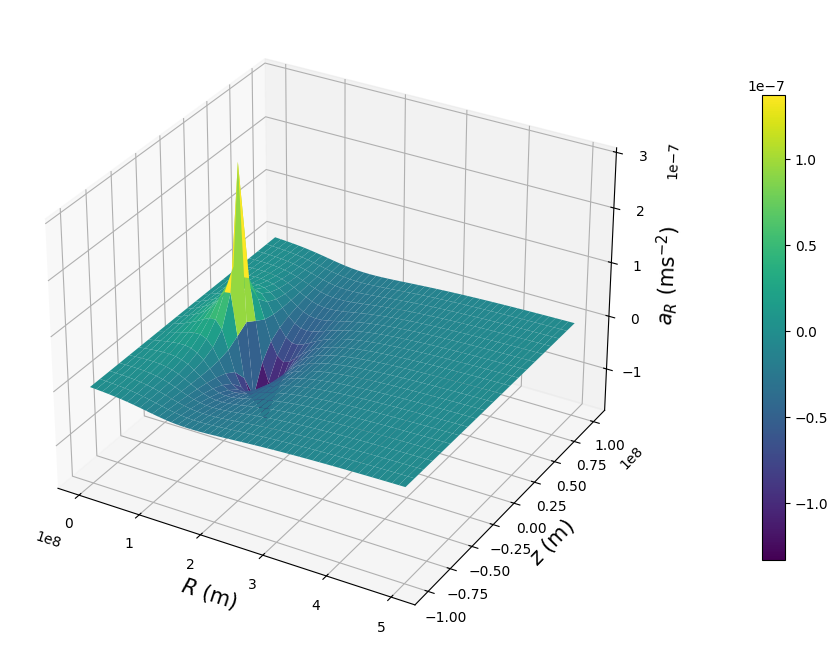

In [24]:
ax = plt.figure(figsize=(10, 10)).add_subplot(projection='3d')

# ax.set_title('Acceleration due to rings of Saturn (theoretical)')

ax.set_xlabel('$R$ (m)')
ax.set_ylabel('$z$ (m)')
ax.set_zlabel('$a_R$ (ms$^{-2}$)')

surface = ax.plot_surface(R_R[:, 0:200], Z_Z[:, 0:200], forces.T[:,0:200], cmap=cm.viridis)

fig.colorbar(surface, fraction=0.03, pad=0.15)

plt.savefig('./images/acceleration due to rings of saturn.pdf')
plt.show()

C:\Users\Alexander\AppData\Local\Temp\ipykernel_1388\2600096351.py:11: UserWarning: Adding colorbar to a different Figure <Figure size 1000x1000 with 2 Axes> than <Figure size 1500x500 with 3 Axes> which fig.colorbar is called on.
  fig.colorbar(surface, fraction=0.03, pad=0.15)


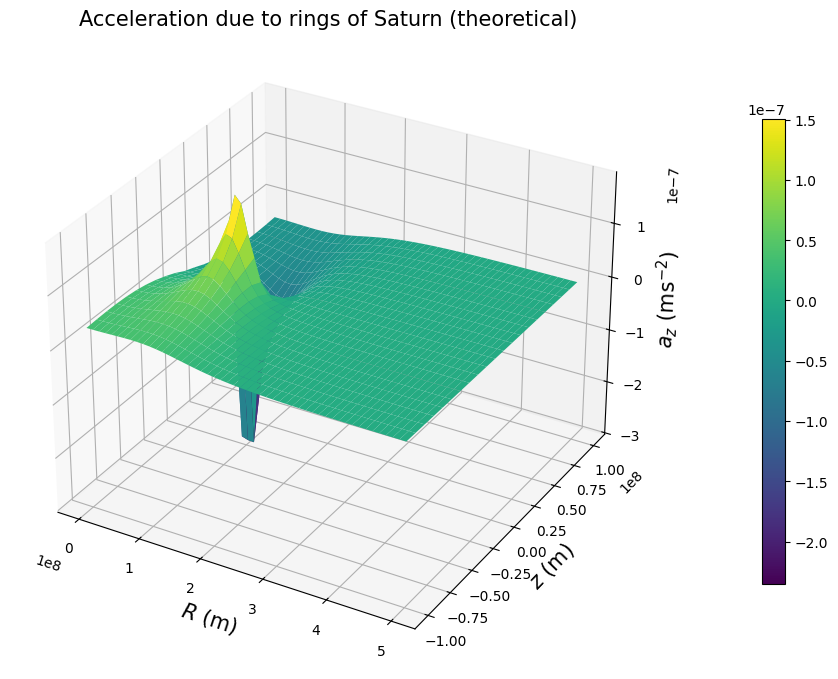

In [26]:
ax = plt.figure(figsize=(10, 10)).add_subplot(projection='3d')

ax.set_title('Acceleration due to rings of Saturn (theoretical)')

ax.set_xlabel('$R$ (m)')
ax.set_ylabel('$z$ (m)')
ax.set_zlabel('$a_z$ (ms$^{-2}$)')

surface = ax.plot_surface(R_R[:, 0:200], Z_Z[:, 0:200], forces_z.T[:,0:200], cmap=cm.viridis)

fig.colorbar(surface, fraction=0.03, pad=0.15)

# plt.savefig('./images/acceleration due to rings of saturn.png', dpi=200)
plt.savefig('./images/acceleration in z due to rings of saturn.pdf')
plt.show()

### Saving matrix data necessary for simulation

Data format is `.bin`, two matrices are saved which are size 500x401.
Values are saved row per 'line' (500 entries), see below and consist of doubles

In [ ]:
def save_as_binary(matrix, file):
    a, b = matrix.shape
    with open(file, 'wb') as f:
        for i in range(0, a):
            values = matrix[i, :]
            values = struct.pack(f'{b}d', *values)
            f.write(values)
            # for j in range(0, b):
            #     value = float(matrix[i][j])
            #     f.write(bytes())
        f.close()

    # print(a, b)


save_as_binary(forces, f'forces_r_{len(R)}x{len(z)}.bin')
save_as_binary(forces_z, f'forces_z_{len(R)}x{len(z)}.bin')

### Tests for binary file & linear approximation

Code is commented out since it requires the files to exist which will cause errors on execution.
Interpolation is translated into C++ so this is not a definitive version of the interpolation code.

In [ ]:
# forces_testload = np.zeros((200, 101))

# with open('forces_r_200x101.bin', 'rb') as f:
#     for i in range(0, 200):
#         values = f.read(8 * 101)
#         forces_testload[i, :] = struct.unpack('101d', values)
#         # for j in range(401):
#         #     forces_testload[i][j] = float(bytes(f.read(4)))

# # np.all(forces_testload == forces)

In [ ]:
# cur_pos = np.array([0.9e8 * np.cos(np.pi/4), 0.9e8 * np.cos(np.pi/4), 0.5e8])
# cur_R = np.sqrt(cur_pos[0]**2 + cur_pos[1]**2)
# calc_dR = 5e8/(500-1)
# index_R = (int(np.floor(cur_R / calc_dR)), int(np.ceil(cur_R / calc_dR))) 
# calc_dz = 200e6/(401-1)
# index_z = (int(np.floor(cur_pos[2] / calc_dz)) + 200, int(np.ceil(cur_pos[2] / calc_dz)) + 200)

# # print(index_R, index_z)

# interp_R = (cur_R - R[index_R[0]])/calc_dR
# interp_z = (cur_pos[2] - z[index_z[0]])/calc_dz

# print(interp_R, interp_z)
# print(index_z)

# forces_R_points = [forces[index_R[0], index_z[0]], forces[index_R[1], index_z[0]],
#                    forces[index_R[0], index_z[1]], forces[index_R[1], index_z[1]]]

# forces_z_points = [forces_z[index_R[0], index_z[0]], forces_z[index_R[1], index_z[0]],
#                    forces_z[index_R[0], index_z[1]], forces_z[index_R[1], index_z[1]]]

# forces_R_halfway = [(forces_R_points[0] + forces_R_points[1])/2, (forces_R_points[2] + forces_R_points[3])/2]
# forces_z_halfway = [(forces_z_points[0] + forces_z_points[1])/2, (forces_z_points[2] + forces_z_points[3])/2]
# cur_forces_R = np.mean(forces_R_halfway)
# cur_forces_z = np.mean(forces_z_halfway)

# cur_force = np.array([
#     cur_pos[0]/cur_R * cur_forces_R,
#     cur_pos[1]/cur_R * cur_forces_R,
#     cur_forces_z
# ])

# print(cur_force)

IndexError: index 89 is out of bounds for axis 0 with size 50

In [3]:
# ax = plt.figure(figsize=(10, 10)).add_subplot(projection='3d')

# ax.set_xlabel('R')
# ax.set_ylabel('z')
# ax.set_zlabel('$\\nabla V$')

# ax.plot_surface(R_R, Z_Z, forces.T)

# plt.show()

In [4]:
# # plt.xticks(R[:, 0], np.arange(0, 3, 1))
# # plt.yticks(z[0, :], np.arange(-10, 10, 1))
# # plt.imshow(potential)

# plt.xlabel('R')
# plt.ylabel('z')
# plt.contourf(R, z, forces.T, 50)a

# # plt.axvline(r0)
# # plt.axvline(r1)

# plt.colorbar()

# plt.show()

### Potential

Analysis of potential due to Saturn's rings.

In [15]:
# R = np.linspace(5e8, 10e9, 500) # 50e6, 500e6

# R = np.linspace(1e6, 5e8, 40) # 500
R = np.linspace(1e6, 5e8, 50) # 500

# R = np.linspace(5e8, 100e8, 30)
# approximation GM/r from 5e7
z = np.linspace(-100e6, 100e6, 20+1) # 401
# z = np.linspace(-5, 0, 5, 3)

R_R, Z_Z = np.meshgrid(R, z)

In [16]:
potential = np.zeros((len(R), len(z)))

# @jit(nopython=True, parallel=True)
def generate_potential():
    for i in range(len(R)):
        for j in range(len(z)):
            R0 = R[i]
            z0 = z[j]
            potential[i, j] = pot_rings(R0, z0, quadrature=False)

generate_potential()

# generate_potential.parallel_diagnostics(level=4)

### Contributions to the ring potential

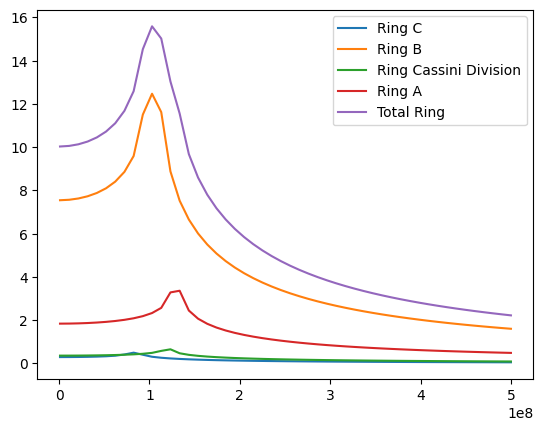

In [60]:
for ring in rings:
    test_pot = np.zeros_like(R)
    for i in range(len(R)):
        R0 = R[i]
        z0 = 0
        test_pot[i] = pot(R0, z0, quadrature=False, ring=ring)
        
    plt.plot(R, test_pot, label=f'{ring.name}')

plt.plot(R, potential[:,10], label='Total Ring')
plt.legend()
plt.show()

In [ ]:
# %lprun -f generate_potential -f pot -f laplacian_besselproduct generate_potential()

### Surface plots of potential

C:\Users\Alexander\AppData\Local\Temp\ipykernel_1388\1452632139.py:8: UserWarning: Adding colorbar to a different Figure <Figure size 1200x1200 with 2 Axes> than <Figure size 1500x500 with 3 Axes> which fig.colorbar is called on.
  fig.colorbar(surface, fraction=0.02, pad=0.04)


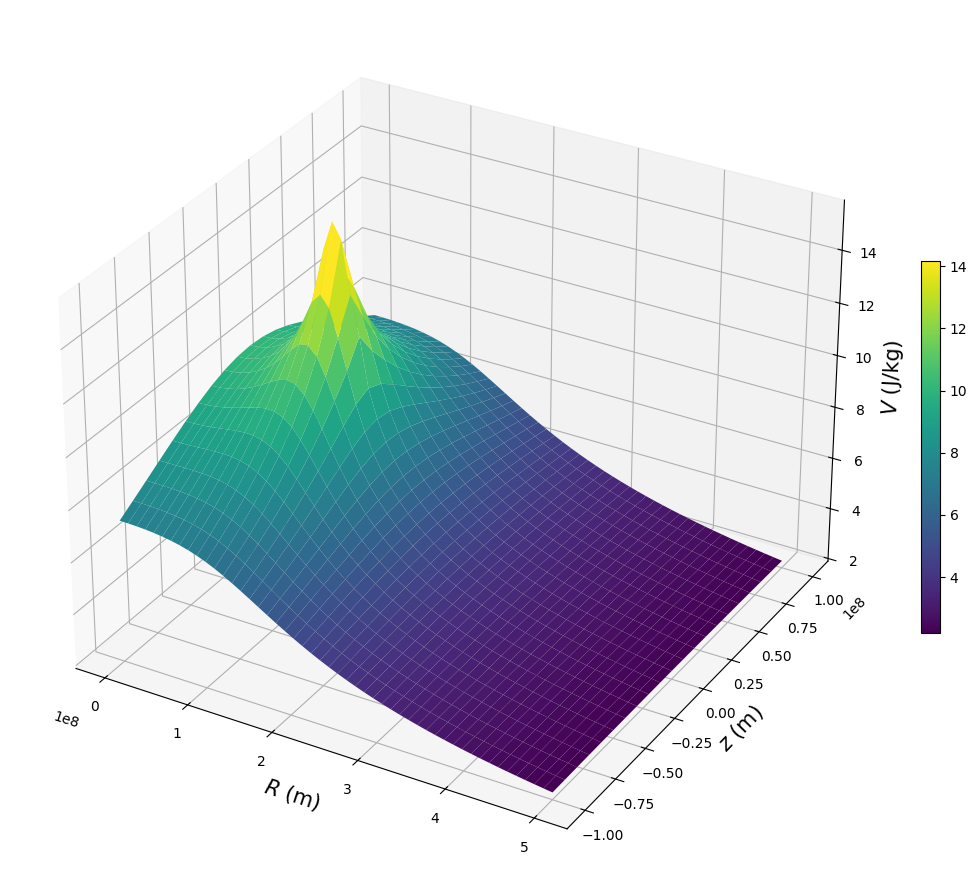

In [20]:
ax = plt.figure(figsize=(12, 12)).add_subplot(projection='3d')

ax.set_xlabel('$R$ (m)')
ax.set_ylabel('$z$ (m)')
ax.set_zlabel('$V$ (J/kg)')

surface = ax.plot_surface(R_R, Z_Z, potential.T, cmap=cm.viridis)
fig.colorbar(surface, fraction=0.02, pad=0.04)

plt.savefig('./images/potential due to saturn.pdf')
plt.show()

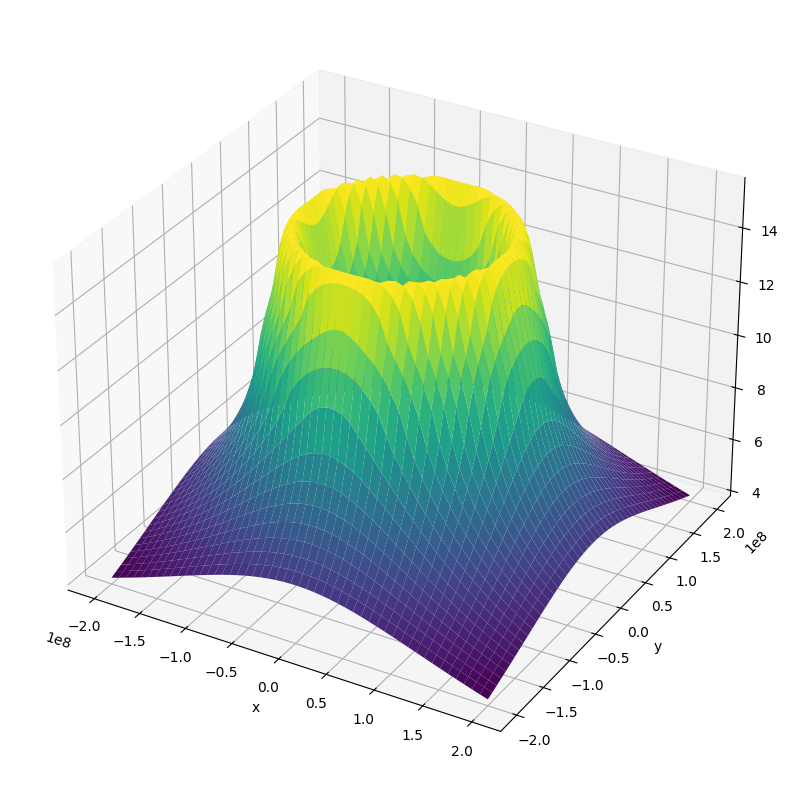

In [62]:
X = np.linspace(-2e8, 2e8, 50)
Y = np.copy(X)
potential_xy = np.zeros((len(X), len(Y)))

# @jit(nopython=True, parallel=True)
for i in range(len(X)):
    for j in range(len(Y)):
        x = X[i]
        y = Y[j]
        R0 = np.sqrt(x**2 + y**2)
        z0 = 0
        potential_xy[i, j] = pot_rings(R0, z0, quadrature=False)

ax = plt.figure(figsize=(10, 10)).add_subplot(projection='3d')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$V$')

X, Y = np.meshgrid(X, Y)
ax.plot_surface(X, Y, potential_xy.T, cmap=cm.viridis)

plt.show()

### Obsolete analysis

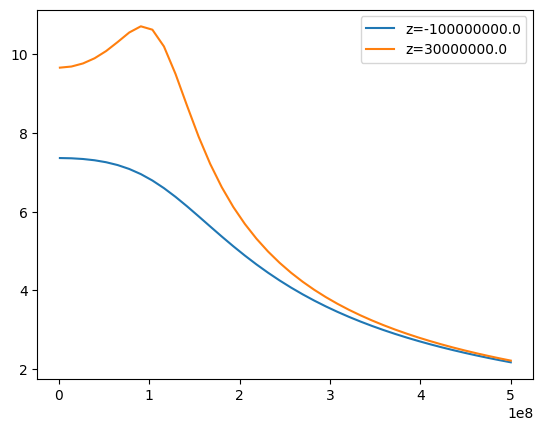

In [165]:
for k in range(0, len(z)):
    if k % 13 == 0:
        plt.plot(R, potential[:, k], label=f'z={z[k]}')

plt.legend()
plt.show()

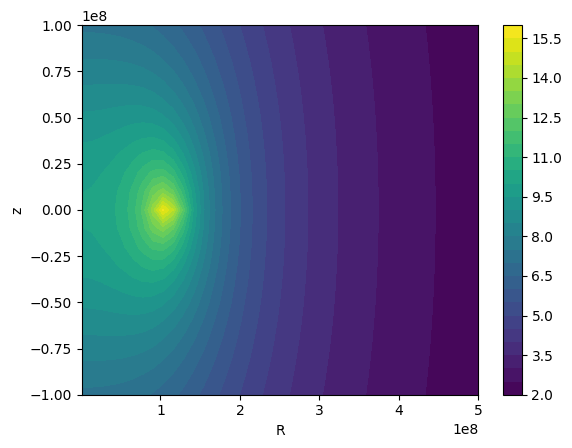

In [166]:
# plt.xticks(R[:, 0], np.arange(0, 3, 1))
# plt.yticks(z[0, :], np.arange(-10, 10, 1))
# plt.imshow(potential)

plt.xlabel('R')
plt.ylabel('z')
plt.contourf(R, z, potential.T, 30)

plt.colorbar()

plt.show()